### Note:
#### All the running time recorded are for reference only. In our case, the total number of samples for training and testing are 36000 and 4000.
#### We observed that the running time for data loading and sampling are relatively constant (< 1 min). 
#### The running time  for training and testing phases would slightly vary depending on the sample size. 

In [2]:
%env PYTHONHASHSEED=0 
!pip3 install nltk

env: PYTHONHASHSEED=0
  Using cached https://files.pythonhosted.org/packages/65/26/32b8464df2a97e6dd1b656ed26b2c194606c16fe163c695a992b36c11cdf/six-1.13.0-py2.py3-none-any.whl


In [10]:
import sys
sys.path.append('/usr/local/share/jupyter/kernels/python3')

In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /u6/b6xia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import findspark
findspark.init("/u/cs451/packages/spark")
from time import perf_counter

### Spark Session Configuration and Data Loading (~ 32 sec)

In [3]:
from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[4]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()


In [4]:
start = perf_counter()
print('Loading Dataset...')
review = spark.read.json("/u/cs451/yelp/review.json")
elapsed_time = perf_counter() - start
print(f'Finished in {elapsed_time:.2f} sec')

Loading Dataset...
Finished in 33.94 sec


In [5]:
# total number of reviews
review.count() 

6685900

In [14]:
review.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ujmEBvifdJM6h6RLv...|   0|2013-05-07 04:34:36|    1|Q1sbwvVQXV2734tPg...|    1|Total bill for th...|     6|hG7b0MtEbXx5QzbzE...|
|NZnhc2sEQy3RmzKTZ...|   0|2017-01-14 21:30:33|    0|GJXCdrto3ASJOqKeV...|    5|I *adore* Travis ...|     0|yXQM5uF2jS6es16SJ...|
|WTqjgwHlXbSFevF32...|   0|2016-11-09 20:09:03|    0|2TzJjDVDEuAW6MR5V...|    5|I have to say tha...|     3|n6-Gk65cPZL6Uz8qR...|
|ikCg8xy5JIg_NGPx-...|   0|2018-01-09 20:56:38|    0|yi0R0Ugj_xUx_Nek0...|    5|Went in for a lun...|     0|dacAIZ6fTM6mqwW5u...|
|b1b1eb3uo-w561D0Z...|   0|2018-01-30 23:07:38|    0|11a8sVPMUFtaC7_AB...|    1|Today was 

In [21]:
review.groupBy("stars").count().sort('stars',ascending=True).show()

+-----+-------+
|stars|  count|
+-----+-------+
|    1|1002159|
|    2| 542394|
|    3| 739280|
|    4|1468985|
|    5|2933082|
+-----+-------+



In [13]:
review.rdd.getNumPartitions()

40

In [104]:
# change the number of partitions
# review=review.coalesce(20)
# review.rdd.getNumPartitions()

20

### Data Cleaning and Sampling (~ 22 sec)

#### Only two columns (stars and text) of interest are selected. Stars range from 1 to 5. In this project, Review comments with 1, 2 stars are regarded as  bad reviews, and comments with 5 stars are regarded as good reviews. num_samples_per_label is approximated number of samples for either good or bad comments after sampling the raw data.


In [18]:
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType

num_samples_per_label = 5000
frac = num_samples_per_label * 3.33e-7

review = review.withColumn('stars', review.stars.cast(IntegerType()))
sampled = review.select(review.stars, review.text).sampleBy('stars', fractions={1:frac*2, 2:frac*2, 3:0, 4:0, 5:frac}).cache()
start = perf_counter()
print('Making Queries...')
sampled.groupBy(sampled.stars).agg(count('*')).show()
elapsed_time = perf_counter() - start
print(f'Finished in {elapsed_time:.2f} sec')

Making Queries...
+-----+--------+
|stars|count(1)|
+-----+--------+
|    1|    3325|
|    5|    4770|
|    2|    1864|
+-----+--------+

Finished in 22.55 sec


In [19]:
sampled.count()

9959

In [35]:
sampled.rdd.getNumPartitions()

40

### Define Functions for Text Parsing and Normalization.
#### Tokenization: Remove empty spaces, punctuations and numbers. Convert the string into list of lowercase tokens.
#### Stop Words Removal: Ignore frequent words that are deemed irrrelevent for sentiment analysis. (e.g. the, a)
#### Lemmatization: Reduces the inflected words properly to its canonical form (e.g. tried -> try)

In [7]:
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']

def normalize(text):
    tokens = re.findall('[a-zA-Z\']+', text)
    tokens_without_stop_words = [lemmatizer.lemmatize(i.lower(), pos='v') for i in tokens if i.lower() not in stop_words]
    return tokens_without_stop_words

def parse_training_RDD(line):
    stars, text = line
    label = 'bad' if stars < 5 else 'good'
    tokens_without_stop_words = normalize(text)
    return list(zip(tokens_without_stop_words, [label] * len(tokens_without_stop_words)))

### Data Preprocessing ( ~ 13 sec)
#### Convert the Spark DataFrame to RDD.
#### Split Dataset into Training and Testing with Ratio 9 : 1. 
#### Apply Text Parsing and Normalization on Training Set.
#### Compute Single-Token Probability for both labels.

In [25]:
print('Data Preprocessing...')
start = perf_counter()
review_RDD = sampled.rdd.map(tuple)
review_RDD_training, review_RDD_testing = review_RDD.randomSplit([9, 1], 17)
token_RDD = review_RDD_training.flatMap(lambda e : parse_training_RDD(e)).cache()

num_good_tokens = token_RDD.filter(lambda e : e[1] == 'good').count()
num_bad_tokens = token_RDD.filter(lambda e : e[1] == 'bad').count()
single_token_probs = {'good': (1 / (num_good_tokens)), 'bad': (1 / (num_bad_tokens))}
elapsed_time = perf_counter() - start
print(f'Finished in {elapsed_time:.2f} sec')

Data Preprocessing...
Finished in 10.49 sec


### Training Phase (~ 12 sec)
#### Generating Probability Lookup Table.
#### Saving the  Trained Model to Directory: output_model.

In [26]:
import shutil, os

output_model='models/naive_bayes_model'

print('Generating Lookup Table...')
start = perf_counter()
token_prob_RDD = token_RDD.map(lambda e : (e, single_token_probs['good'] if e[1] == 'good' else single_token_probs['bad'])) \
                 .reduceByKey(lambda p1, p2 : p1 + p2) \
                 .map(lambda e : (e[0][0], (e[0][1], e[1]))).cache()

good_tokens = token_prob_RDD.filter(lambda e : e[1][0] == 'good').map(lambda e : e[0]).collect()
bad_tokens = token_prob_RDD.filter(lambda e : e[1][0] == 'bad').map(lambda e : e[0]).collect()
model_RDD = token_prob_RDD.groupByKey().mapValues(lambda e : list(e)).cache()

if os.path.isdir(output_model):
    print('Deleting Previous Model...')    
    shutil.rmtree(output_model)
print(f'Saving Current Model to directory: \'{output_model}\'')
model_RDD.saveAsTextFile(output_model)
model = model_RDD.collectAsMap()
elapsed_time = perf_counter() - start
print(f'Finished in {elapsed_time:.2f} sec')

Generating Lookup Table...
Deleting Previous Model...
Saving Current Model to directory: 'models/naive_bayes_model'
Finished in 21.29 sec


### Testing Phase (~ 6 sec)
#### Note: Data are sampled so that each label has approximately same number of samples. Thus, the prior for each label is ignored.

In [29]:
from math import log

def posterior(tokens, model):
    posteriors = {}
    num_absent_tokens = 0
    for token in tokens:
        if token not in model:
            num_absent_tokens += 1
            continue
        probs = model[token]
        if len(probs) == 1:
            label, p = probs[0]
            posteriors[label] = posteriors[label] + log(p) if label in posteriors else log(p)
            missing_label = 'good' if label == 'bad' else 'bad'
            missing_p = single_token_probs[missing_label]
            posteriors[missing_label] = posteriors[missing_label] + log(missing_p) if missing_label in posteriors else log(missing_p)
        else:
            for prob in probs:
                label, p = prob
                posteriors[label] = posteriors[label] + log(p) if label in posteriors else log(p)

    for label in ['good', 'bad']:
        posteriors[label] = posteriors[label] + log(single_token_probs[label]) * num_absent_tokens if label in posteriors else log(single_token_probs[label])
    return posteriors

def predict(line, model):
    stars, text = line
    label = 'bad' if stars < 5 else 'good'
    is_bad = 1 if label == 'bad' else 0
    is_good = 1 - is_bad
    tokens_without_stop_words = normalize(text)
    posteriors = posterior(tokens_without_stop_words, model)
    prediction = 'good' if posteriors['good'] > posteriors['bad'] else 'bad'
    prob_good = posteriors['bad'] / (posteriors['good'] + posteriors['bad'])
    prob_bad = 1 - prob_good
    return is_good, is_bad, prob_good, prob_bad, label == prediction

print('Making Predictions...')
start = perf_counter()
result_RDD = review_RDD_testing.map(lambda line : predict(line, model)).cache()
num_testing_instance = result_RDD.count()
elapsed_time = perf_counter() - start
print(f'Finished in {elapsed_time:.2f} sec')

Making Predictions...
Finished in 6.15 sec


### Evaluation Phase
#### Computing Accuracy

In [30]:
accuracy = result_RDD.filter(lambda e : e[4]).count() / num_testing_instance * 100
print(f'The classification accuracy of {num_testing_instance} testing samples: {accuracy:.2f}%')

The classification accuracy of 1021 testing samples: 90.60%


#### Generating ROC Plot

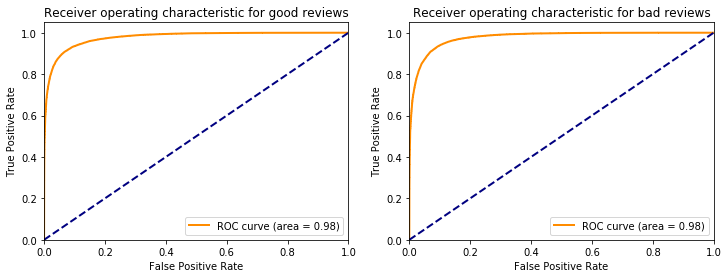

In [41]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

result = np.array(result_RDD.map(lambda e : list(e[:-1])).collect())
y_test = result[:, :2].astype(np.int)
y_score = result[:, 2:]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure(figsize=(12, 4))
for i in range(2):
    labels = ['good', 'bad']
    plt.subplot(1,2,(i+1))
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {labels[i]} reviews')
    plt.legend(loc="lower right")

plt.show()